In [1]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')


## Build the model

In [2]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[2] price[N];  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  int<lower=0> ndisc;  //number of discount prices
  real price_pred[nprice]; //price points for predictions
  real price_discount_pred[ndisc];
  int<lower=1> P; //number of products
  int<lower=1> product[N]; //product for observation n
}

parameters {
  vector[K] c_raw[P];              // effect of place for k
  row_vector[2] m[P]; // slope;
  vector[K] hier_c_mean; 
  cholesky_factor_corr[K] L_Omega;
  vector<lower=0>[K] tau;      // prior scale

  
  }

transformed parameters {
vector[K] c[P];

for (i in 1:P){
c[i]=hier_c_mean + (diag_pre_multiply(tau,L_Omega) * c_raw[i]);
}

}


model {
for (i in 1:P){
m[i] ~ std_normal();
c_raw[i] ~std_normal();
}
hier_c_mean~normal(0,3);
L_Omega ~ lkj_corr_cholesky(2);
tau ~ normal(0, 1);

  if (N > 1){
  for (i in 1:N){
  y[i] ~ bernoulli_logit(m[product[i]]*price[i] + c[product[i],kk[i]]);
  }
  }
}

generated quantities {
vector[N] y_rep;
matrix[ndisc,nprice] pred_matrix[P,K];
matrix[ndisc,nprice] pred_matrix_select[P,K];
if (N<2)
for (i in 1:nprice){
for (d in 1:ndisc){
for (j in 1:K){
for (z in 1:P){
pred_matrix[z,j,d,i]=m[z,1]*price_pred[i] + m[z,2]*price_discount_pred[d]+c[z,j];
pred_matrix_select[z,j,d,i]=bernoulli_logit_rng(pred_matrix[z,j,d,i]);
}
}
}
}
if (N > 1){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m[product[i]]*price[i] + c[product[i],kk[i]]);
}
}
}
"""

In [3]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3dd0758e2d5135fb8922075a09591294 NOW.


# Fit model to real UK data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

In [8]:
data_all=pd.read_csv('../data/raw/uk-scenario-real-data.csv')

In [9]:
data_all

,Unnamed: 0,trial_index,shelf_index,product_index,product,price,selected,scenario,latency,pre_discounted,id.session
0,1723,0,0,0,smirnoff_large,19.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
1,1724,0,0,1,blossom_red,4.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
2,1725,0,0,2,canti_prosecco,9.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
3,1726,0,0,3,malibu,18.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
4,1727,0,0,4,smirnoff,12.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
5,1728,0,0,5,gordons,19.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
6,1729,0,0,6,edinburgh_gin,27.99,True,B6-fill_15,35381.0,NaN,5de21ae2625af00010e78299
7,1730,0,0,7,blossom_white,4.99,False,B6-fill_15,NaN,NaN,5de21ae2625af00010e78299
8,1731,1,0,0,aperol,14.99,False,B5-23,NaN,NaN,5de21ae2625af00010e78299
9,1732,1,0,1,tesco_finest_saltedcaramel,11.99,False,B5-23,NaN,NaN,5de21ae2625af00010e78299


select the data from appropriate scenarios (i.e. not fill)

In [10]:
ind=[('B5' in i) & ('fill' not in i) for i in data_all['scenario']]

In [11]:
data=data_all[ind]

Transform data and add mean subtracted columns

In [12]:
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
data['product_int']=data.groupby('product').grouper.group_info[0]+1
# if pre-discounted ==NaN, set to pre dicounted price
data['pre_discounted'][np.isnan(data['pre_discounted'])]=data['price'][np.isnan(data['pre_discounted'])]
# transform to mean subtracted price
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']
# transform to mean subtracted price
data['mean_sub_price_pre_discounted']=data['pre_discounted']-data.groupby('product').transform('mean')['price']

In [13]:
data[0:5]

,Unnamed: 0,trial_index,shelf_index,product_index,product,price,selected,scenario,latency,pre_discounted,id.session,id.session_int,selected_int,product_int,mean_sub_price,mean_sub_price_pre_discounted
8,1731,1,0,0,aperol,14.99,False,B5-23,NaN,14.99,5de21ae2625af00010e78299,1,0,1,-1.776357e-15,-1.776357e-15
9,1732,1,0,1,tesco_finest_saltedcaramel,11.99,False,B5-23,NaN,11.99,5de21ae2625af00010e78299,1,0,8,-1.776357e-15,-1.776357e-15
10,1733,1,0,2,baileys_700ml,11.99,True,B5-23,7395.0,14.99,5de21ae2625af00010e78299,1,1,2,-1.297025e+00,1.702975e+00
11,1734,1,0,3,southern_comfort,20.99,False,B5-23,NaN,20.99,5de21ae2625af00010e78299,1,0,7,-3.552714e-15,-3.552714e-15
12,1735,1,0,4,tia_maria,14.99,False,B5-23,NaN,14.99,5de21ae2625af00010e78299,1,0,9,-1.776357e-15,-1.776357e-15


## Fit model to data

In [15]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data),
    'price':data.iloc[:,-2:].values,# the price and prediscount price columns (mean subtracted)
    'kk':data['product_index'].values+1,
    'y':data['selected_int'],
    'nprice':10,
    'ndisc':10,
    'price_pred':np.arange(-5,5,1.0),
    'price_discount_pred':np.arange(-5,5,1.0),
    'P':data['product_int'].unique().size,
    'product':data['product_int']
    }



In [16]:
fit_infer=sm.sampling(data=data_infer,chains=2,iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [17]:
pystan.check_hmc_diagnostics(fit_infer)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

`n_eff` and `R_hat` are False because of replicated data being generated so not a problem

### Hierarchical parameters

#### $\Sigma$: The covariance matrix for hierarchical position

In [18]:
Sigma=np.empty((fit_infer['tau'].shape[0],fit_infer['tau'].shape[1],fit_infer['tau'].shape[1]))
for s in range(0,fit_infer['tau'].shape[0]):
    Sigma[s,:,:]=np.matmul(np.diag(fit_infer['tau'][s,:]),np.matmul(np.matmul(fit_infer['L_Omega'][s,:,:],fit_infer['L_Omega'][s,:,:].T),np.diag(fit_infer['tau'][s,:])))

Text(0.5, 1, 'Std. Dev. $\\Sigma$')

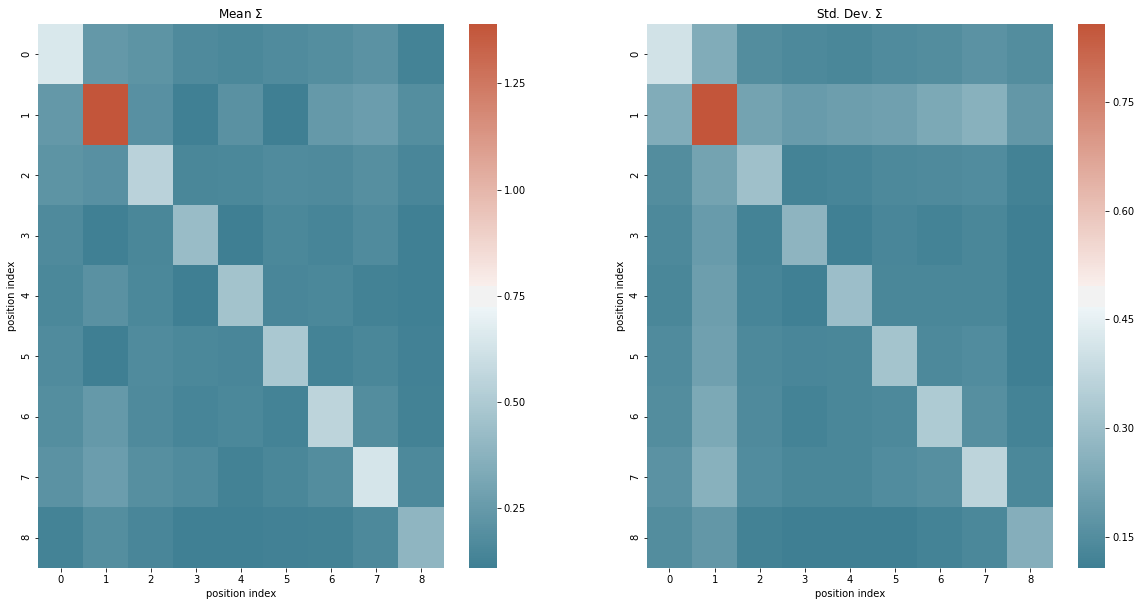

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.heatmap(np.mean(Sigma,axis=0),cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.xlabel('position index')
plt.ylabel('position index')
plt.title('Mean $\Sigma$')
plt.subplot(1,2,2)
sns.heatmap(np.std(Sigma,axis=0),cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.xlabel('position index')
plt.ylabel('position index')
plt.title('Std. Dev. $\Sigma$')

The plot above shows the mean and standard deviation for the covariance matrix related to the hierarchical position parameter. The off-diagonal elements of the covariance matrix tells us how the positions are related with one another. For example,
* if the off-diagonal elements are positive, it means if the clicks for a particular project are high in one position, they will be high in the second position
* If the off-diagonal elements are negative, it means if the clicks for a particular project are high in one position, they will be low in the second position.
* If the off-diagonal elements are close to zero, then there is no correlation between positions.

As can be seen in the plots above, the mean off-diagnonal elements are close to zero so, given the data we have, there does not appear to be much correlation between positions.

The diagonal elements are the traditional $\sigma^2$ for each position. The larger the $\sigma^2$, the more dispersion on the position parameter, with the intuitive interpretation of this is that different products behave differently at the same position, where as smaller $\sigma^2$ would indicate that different products find a similar effect for position.



#### $\sigma$: Marginalised uncertianty on hierarchical position
This is another way of visualising the diagnonal elements of the covariance matrix

Text(0, 0.5, 'Hierarchical C $\\sigma^2_{ii}$')

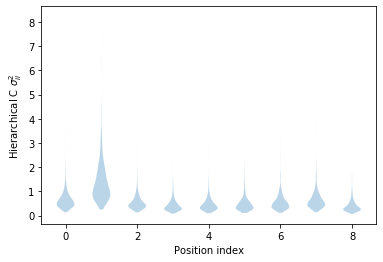

In [20]:
plt.violinplot(fit_infer['tau'][:,:]**2,showextrema=False,positions=data['product_index'].unique());
plt.xlabel('Position index')
plt.ylabel(r'Hierarchical C $\sigma^2_{ii}$')

#### $\mu$: Mean hierarchical position
This parameter gives us the mean position for the hierarchical distribution. A position that has a lower mean C will have less chance of being selected. The plot above shows the posterior probability distribution of the mean hierarchical c value.

Text(0, 0.5, 'Hierarchical C Mean')

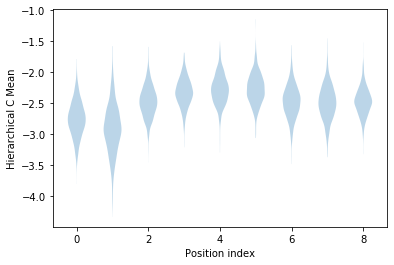

In [21]:
plt.violinplot(fit_infer['hier_c_mean'],showextrema=False,positions=data['product_index'].unique());
plt.xlabel('Position index')
plt.ylabel('Hierarchical C Mean')

#### Full distribution on hierarchical position and relevance for individual position parameters
So far, we have looked at the mean and covariance matrix for the hierarchical parameters. In this model, we are assuming the distribution of c values for each product follows a normal distribtion, with a mean and covariance matrix given above. However, we have uncertainty on the mean and covariance as already demonstrated. We can propagate that uncertainty through to get the full hierarchical probability distribution for C, for which the indivual c values for each product are drawn from. 

The plot below shows that propagated distribution, with the posterior probability distribution for the individual c values plotted on top for each product. Because of the limited number of positions tried for each product in this dataset, the distributions are not that informative.

In [22]:
hier_dist=np.zeros((10,fit_infer['hier_c_mean'].shape[0],fit_infer['hier_c_mean'].shape[1]))
for i in range(0,fit_infer['hier_c_mean'].shape[0],100):
    for z in range(0,fit_infer['hier_c_mean'].shape[1]):
        hier_dist[:,i,z]=np.random.normal(fit_infer['hier_c_mean'][i,z]
                                          ,fit_infer['tau'][i,z]**2,10)


Text(0, 0.5, 'C')

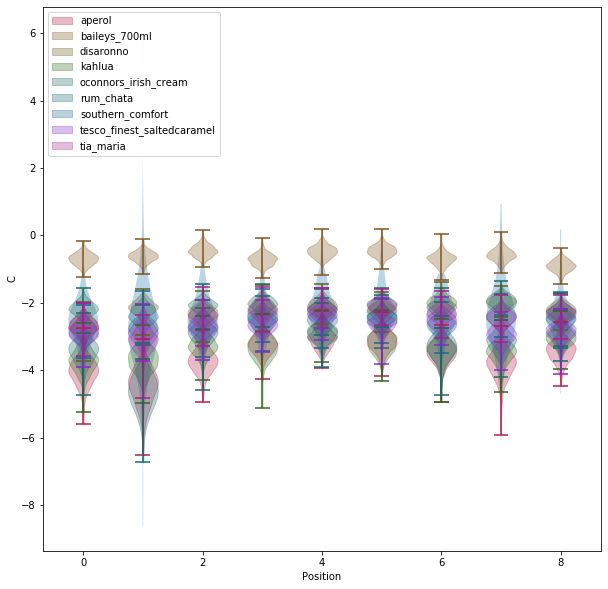

In [23]:
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

plt.figure(figsize=(10,10))
labels=[]
c=sns.husl_palette(np.unique(fit_infer.data['product'].values).size,l=.4)
plt.violinplot(hier_dist[:,::100,:].reshape(100,data['product_index'].unique().size),showextrema=False,positions=data['product_index'].unique());
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    ind=fit_infer.data['product']==pro
    violin_parts=plt.violinplot(fit_infer['c'][:,z,np.unique(fit_infer.data['kk'][ind])-1],positions=np.unique(fit_infer.data['kk'][ind])-1);
    for pc in violin_parts['bodies']:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    for pc in [violin_parts[i] for i in ['cbars','cmins','cmaxes']]:
            pc.set_facecolor(c[z])
            pc.set_edgecolor(c[z])
    add_label(violin_parts,np.unique(data[data['product_int']==pro]['product'])[0])
plt.legend(*zip(*labels), loc=2)
plt.xlabel('Position')
plt.ylabel('C')

### Slopes (m): The impact of price

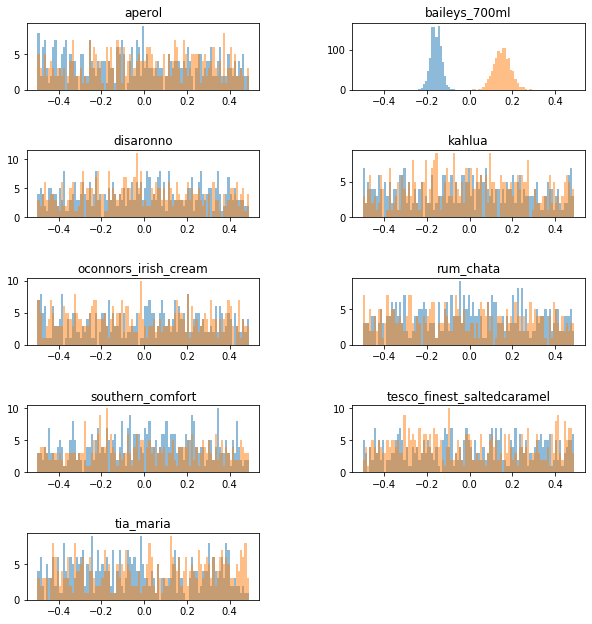

In [24]:
plt.figure(figsize=(10,20))
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    plt.subplot(np.unique(fit_infer.data['product'].values).size,2,z+1)
    plt.hist(fit_infer['m'][:,z,0],bins=np.arange(-0.5,0.5,0.01),alpha=0.5);
    plt.hist(fit_infer['m'][:,z,1],bins=np.arange(-0.5,0.5,0.01),alpha=0.5);

    plt.title(np.unique(data[data['product_int']==pro]['product'])[0])
plt.subplots_adjust(hspace=0.9,wspace=0.4)

### Posterior predictive checks
When examining goodness of fits, the typical method is to compare the data with replicated data from the model, using the best result for parameters. Because we have a full posterior distribution of replicated data, which captures the uncertainty from our model (e.g. on parameters in the model), we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, Gelman et al. 1996 is a good starting point.

Its normally best to start with visual checks. For this, we can see whether the real number of selections over total for each product, price and position combination is consistent with the distribution from our model. The plots below shows this for each product, and the position they were placed in as a function of price.

In [25]:
counts_data=[]
counts_rep=[]
pi=0
for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
    print(z)
    ind=fit_infer.data['product']==pro
    for j,pri in enumerate(np.unique(fit_infer.data['price'][:,0][ind])):
        for d, disc in enumerate(np.unique(fit_infer.data['price'][:,1][ind])):
            ind_all=(fit_infer.data['price'][:,0]== pri
                        ) & (fit_infer.data['product'].values == pro
                            ) & (fit_infer.data['price'][:,1]== disc)
            ind_select=fit_infer.data['y'][ind_all].values==1
            counts_data.append([pro,pi,pri,disc,ind_select.sum()/ind_all.sum(),ind_all.sum()])
            ind_dist=fit_infer['y_rep'][:,ind_all]==1
            counts_rep.append([ind_dist.sum(axis=1)/ind_all.sum()])
            
counts_data=np.asarray(counts_data)
counts_rep=np.vstack(counts_rep).T

0
1
2
3
4
5
6
7
8


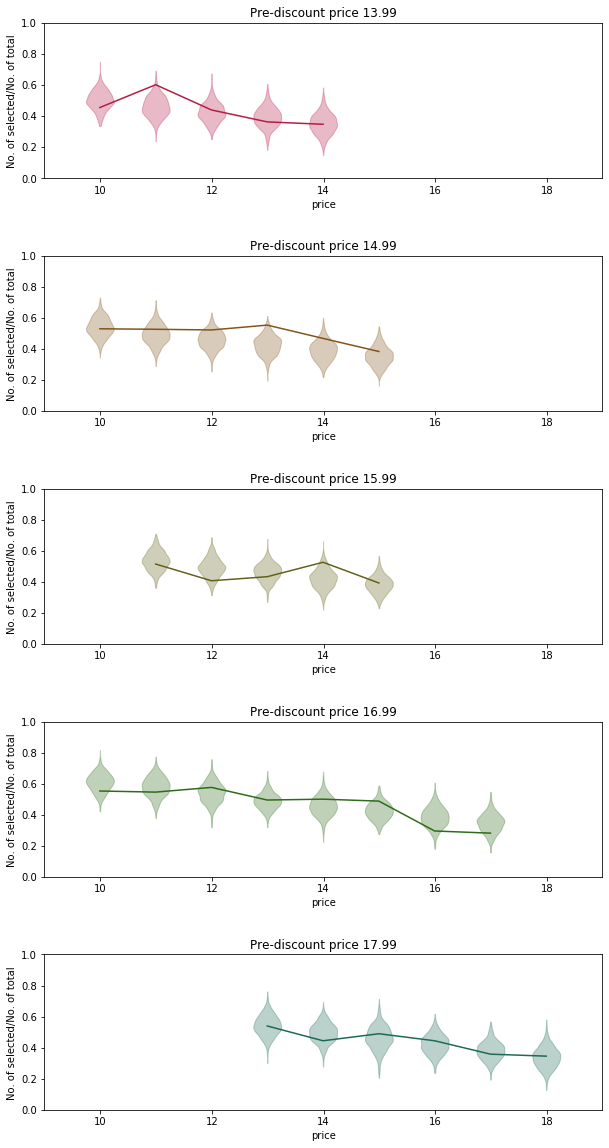

In [27]:
scenario='uk_b5_'
#color=['blue','orange','green','red','black']
color=sns.husl_palette(np.unique(fit_infer.data['kk']).size,l=.4)
pro=2
plt.figure(figsize=(10,20))
#for z,pro in enumerate(np.unique(fit_infer.data['product'].values)):
ind=fit_infer.data['product']==pro
for i,disc in enumerate(np.unique(fit_infer.data['price'][ind,1])):
    plt.subplot(np.unique(fit_infer.data['price'][ind,1]).size,1,i+1)
    ind_plot=(counts_data[:,0]==pro) & (counts_data[:,3] ==disc)
    violin_parts=plt.violinplot(counts_rep[:,ind_plot],positions=counts_data[ind_plot,2]+
                                np.unique(data.groupby('product').transform('mean')['price'][data['product_int']==pro]),showextrema=False)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(color[i])
        pc.set_edgecolor(color[i])
    plt.plot(counts_data[ind_plot,2]+np.unique(data.groupby('product').transform('mean')['price'][data['product_int']==pro]),counts_data[ind_plot,4],color=color[i],label=str(counts_data[ind_plot,5]))
    #plt.legend()
    plt.title('Pre-discount price {:4.2f}'.format(disc+np.unique(data.groupby('product').transform('mean')['price'][data['product_int']==pro])[0]))
    #plt.title(np.unique(data[data['product_int']==pro]['product'])[0])
    plt.xlabel('price')
    plt.ylabel('No. of selected/No. of total')
    plt.xlim(np.min(counts_data[:,2]
                   )-1+np.unique(data.groupby('product'
                                             ).transform('mean')['price'][data['product_int']==pro]),
             np.max(counts_data[:,2])+1+np.unique(data.groupby('product'
                                             ).transform('mean')['price'][data['product_int']==pro]))
    plt.ylim(0,1)
    #make dataframe
    #df_tmp=pd.DataFrame(np.vstack((counts_data[ind_plot,2]+np.unique(data.groupby('product').transform('mean')['price'][data['product_int']==pro])
     #                   ,np.percentile(counts_rep[:,ind_plot],[16,50,84],axis=0))).T,columns=['Price','lower','median','upper'])
    #df_tmp.to_csv('../../../data/processed/'+scenario+np.unique(data[data['product_int']==pro]['product'])[0]+'Pre-discount_{:4.2f}'.format(disc+np.unique(data.groupby('product').transform('mean')['price'][data['product_int']==pro])[0])+'.csv')
    
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

The plot above shows the fraction selected over total for each price and position. The lines are from the data, the violin plots are the distributions for our replicated data. The replicated data distribution shows the uncertianty our model has in the fraction. If our model is doing a good job, the lines should roughly fall within the distributions.

## Selection heatmap for price and discount
We can use our model to explore all possible prices and discounts. The easiest way ot visualise this is via a heatmap

In [28]:
@np.vectorize
def expit_vec(x):
    return 1.0/(1.0+np.exp(-x))

In [29]:
mean_price=data.groupby('product_int').describe()['price']['mean'].values

In [30]:
i=1
price_array=np.arange(9,19)
predisc_array=np.arange(13,20)
click_dist=np.zeros((price_array.size,predisc_array.size))
for p,price in enumerate(price_array):
    for d, predisc in enumerate(predisc_array):
        click_dist_tmp=[]
        if price<=predisc:
            for pos in np.arange(0,np.unique(fit_infer.data['kk']).size).astype(int):
                click_dist_tmp.append(expit_vec(fit_infer['m'][:,i,0]*(price-mean_price[i]) + fit_infer['m'][:,i,1]*(predisc-mean_price[i])+fit_infer['c'][:,i,pos]))
            click_dist[p,d]=np.median(np.concatenate(click_dist_tmp))

Text(33.0, 0.5, 'Price')

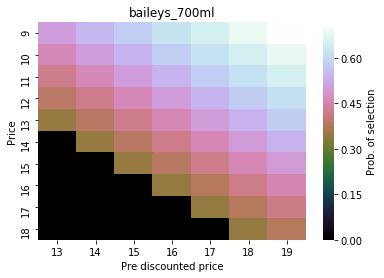

In [31]:

sns.heatmap(click_dist,xticklabels=predisc_array,
            yticklabels=price_array,cmap=sns.color_palette("cubehelix",200),
           cbar_kws={'label': 'Prob. of selection'})
plt.title(np.unique(data[data['product_int']==pro]['product'])[0])
plt.xlabel('Pre discounted price')
plt.ylabel('Price')

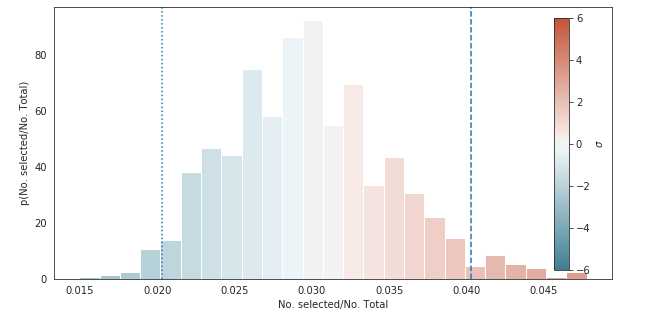

In [34]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(counts_rep[:,0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(counts_rep[:,0]))/np.std(counts_rep[:,0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('No. selected/No. Total')
plt.ylabel('p(No. selected/No. Total)')
plt.axvline(np.mean(counts_rep[:,0])+0.01, linestyle='--')
plt.axvline(np.mean(counts_rep[:,0])-0.01,linestyle=':')
plt.annotate('Ratio higher than \n model can explain',xy=(np.mean(counts_rep[:,0])+0.02, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0])+0.02, 10), textcoords='data',rotation='vertical',size='large')
plt.annotate('Ratio lower than \n model can explain',xy=(np.mean(counts_rep[:,0])-0.02, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0])-0.02, 10), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

As well as carrying out posterior predictive checks visually, we can quantify the fit with something called a Bayesian P value.

We can calculate fraction of $y_{rep}$ samples above and below real ratio. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real ratio, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* ∼0.5 (i.e. near the middle of the distribution) means our model is consistent with the data
* 0.99 or 0.01 (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that $\sigma<−3$ or $\sigma>3$ indicates a problem with the model.

For more information on posterior predictive checks, see:


Bayesian Data Analysis
http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf

In [35]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval

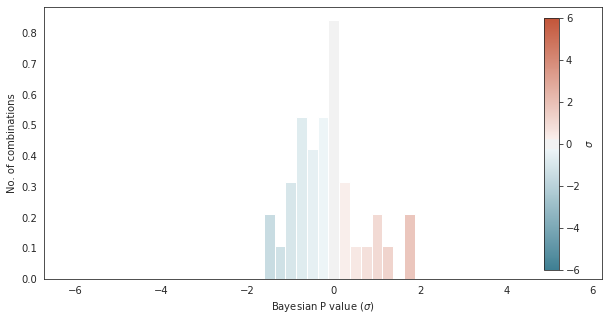

In [36]:
fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

#calculate pvalues for all combinations of price, product and position
pvalues=Bayes_P_value(counts_rep,counts_data[:,4])

# Get the histogramp
Y,X = np.histogram(pvalues, np.arange(-6,6,0.25), normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((x)+6)/12.0) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel(r'Bayesian P value ($\sigma$)')
plt.ylabel('No. of combinations')
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')


The plot above shows the histogram of Bayesian P values for the ratio of selected over all, for all the combinations of products, prices, and position in the data set. The model is consistent with the data if the Bayesian P value is close to zero. Some random deviation will naturally occur which is why if everything is behaving as expected, this should follow a normal distribution, centred on zero. If there were more weight in the tails then this would indicate something is wrong. For example,
* if there were more combinations below -3, then that would tell us the model is producing a higher selection ratio than expected by data.
* if there were more combinations above 3, then that would tell us the model is producing a lower selection ratio than expected by data.

Neither are the case here, the model appears consistent with the data.